In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
pip install spotipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.6/255.6 kB 9.6 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class SpotifyDataHandler:

  __client_id = '9015277f9e524a9abbd2d4cedf2827e7'
  __client_secret = '624f96eeeabe4b03af75c377f8a7704a'

  def _init_(self):
    self.client_credentials_manager = SpotifyClientCredentials(client_id=self.__client_id, client_secret=self.__client_secret)
    self.sp = spotipy.Spotify(client_credentials_manager=self.client_credentials_manager)
    self.track_cache = {}

  def search_song(self, artist_track_pairs):
    queries = [f"{artist} {track}" for artist, track in artist_track_pairs]
    track_results = {}
    for query in queries:
      if query in self.track_cache:
        track_results[query] = self.track_cache[query]
      else:
        result = self.sp.search(q=query, type='track', limit=1)
        if result['tracks']['items']:
            track = result['tracks']['items'][0]
            track_results[query] = track
            self.track_cache[query] = track
        else:
            track_results[query] = None
            self.track_cache[query] = None
    return track_results

  def get_features(self, track_ids):
    try:
      time.sleep(2)
      features = self.sp.audio_features(track_ids)
      return features
    except Exception as e:
      if e.http_status == 429:
        print(f"Rate limit exceeded. Retrying ")
    return features

def fill_missing_values(df):
  song = SpotifyDataHandler()
  track_ids = []
  index_map = {}
  popularity_map = {}

  # Collect track ids and corresponding DataFrame indices
  for index, row in df.iterrows():
    if pd.isna(df.at[index, 'key']) or pd.isna(df.at[index, 'instrumentalness']) or pd.isna(df.at[index, 'Popularity']):
      track = song.search_song(row['Artist Name'], row['Track Name'])
      if track:
        track_ids.append(track['id'])
        index_map[track['id']] = index
        popularity_map[track['id']] = track['popularity']

  # Batch process track ids
  for i in range(0, len(track_ids), 100):
    batch = track_ids[i:i+100]
    features_list = song.get_features(batch)
    # Update DataFrame with features
    for features in features_list:
      index = index_map[features['id']]
      df.at[index, 'key'] = features['key']
      df.at[index, 'instrumentalness'] = features['instrumentalness']
      df.at[index, 'Popularity'] = popularity_map[features['id']]

  return df

In [3]:
X_train = pd.read_csv("/content/drive/MyDrive/music_genre.csv")
X_train.head()

,Id,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,1,Marina Maximilian,Not Afraid,28.0,0.334,0.536,9.0,-6.649,0,0.0381,0.378000,0.000000,0.106,0.235,152.429,204947.0,4,9
1,2,The Black Keys,Howlin' for You,67.0,0.725,0.747,11.0,-5.545,1,0.0876,0.027200,0.046800,0.104,0.380,132.921,191956.0,4,6
2,3,Royal & the Serpent,phuck u,0.0,0.584,0.804,6.0,-6.094,1,0.0619,0.000968,0.000135,0.284,0.635,159.953,161037.0,4,10
3,4,Detroit Blues Band,Missing You,13.0,0.515,0.308,0.0,-14.711,1,0.0312,0.907000,0.021300,0.300,0.501,172.472,298093.0,3,2
4,5,Coast Contra,My Lady,31.0,0.565,0.777,6.0,-5.096,0,0.2490,0.183000,0.000000,0.211,0.619,88.311,254145.0,4,5


In [4]:
X_train.isna().sum()

,0
Id,0
Artist Name,0
Track Name,0
Popularity,22
danceability,0
energy,0
key,190
loudness,0
mode,0
speechiness,0


In [5]:
#X_train = pd.read_csv("/content/my_data.csv")
X_test = pd.read_csv("/content/drive/MyDrive/music-genre-classification-2024/test (2).csv")
X_train.head()

,Id,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,1,Marina Maximilian,Not Afraid,28.0,0.334,0.536,9.0,-6.649,0,0.0381,0.378000,0.000000,0.106,0.235,152.429,204947.0,4,9
1,2,The Black Keys,Howlin' for You,67.0,0.725,0.747,11.0,-5.545,1,0.0876,0.027200,0.046800,0.104,0.380,132.921,191956.0,4,6
2,3,Royal & the Serpent,phuck u,0.0,0.584,0.804,6.0,-6.094,1,0.0619,0.000968,0.000135,0.284,0.635,159.953,161037.0,4,10
3,4,Detroit Blues Band,Missing You,13.0,0.515,0.308,0.0,-14.711,1,0.0312,0.907000,0.021300,0.300,0.501,172.472,298093.0,3,2
4,5,Coast Contra,My Lady,31.0,0.565,0.777,6.0,-5.096,0,0.2490,0.183000,0.000000,0.211,0.619,88.311,254145.0,4,5


In [6]:
train=X_train.copy()

In [7]:
X_train.describe()

,Id,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
count,14396.000000,14374.000000,14396.000000,14396.000000,14206.000000,14396.000000,14396.000000,14396.000000,14396.000000,13912.000000,14396.000000,14396.000000,14396.000000,1.439600e+04,14396.000000,14396.000000
mean,7198.500000,42.326840,0.543105,0.662422,5.392017,-7.900852,0.640247,0.080181,0.246746,0.142163,0.195782,0.486379,122.695372,2.000942e+05,3.924354,6.695679
std,4155.911573,17.915019,0.165517,0.235967,3.498195,4.057362,0.479944,0.085157,0.310922,0.281463,0.159258,0.239476,29.538490,1.116891e+05,0.359520,3.206170
min,1.000000,0.000000,0.059600,0.001210,0.000000,-39.952000,0.000000,0.022500,0.000000,0.000000,0.011900,0.021500,30.557000,5.016500e-01,1.000000,0.000000
25%,3599.750000,30.000000,0.432000,0.508000,2.000000,-9.538000,0.000000,0.034800,0.004280,0.000003,0.097275,0.299000,99.799000,1.654458e+05,4.000000,5.000000
50%,7198.500000,42.000000,0.545000,0.699000,6.000000,-7.013500,1.000000,0.047100,0.081450,0.000517,0.129000,0.480500,120.060000,2.089410e+05,4.000000,8.000000
75%,10797.250000,54.000000,0.658000,0.861000,9.000000,-5.162000,1.000000,0.083100,0.432250,0.076200,0.256000,0.672000,141.988250,2.522470e+05,4.000000,10.000000
max,14396.000000,98.000000,0.989000,1.000000,11.000000,1.342000,1.000000,0.955000,0.996000,0.996000,0.992000,0.986000,217.416000,1.477187e+06,5.000000,10.000000


In [8]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14396 entries, 0 to 14395
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  14396 non-null  int64  
 1   Artist Name         14396 non-null  object 
 2   Track Name          14396 non-null  object 
 3   Popularity          14374 non-null  float64
 4   danceability        14396 non-null  float64
 5   energy              14396 non-null  float64
 6   key                 14206 non-null  float64
 7   loudness            14396 non-null  float64
 8   mode                14396 non-null  int64  
 9   speechiness         14396 non-null  float64
 10  acousticness        14396 non-null  float64
 11  instrumentalness    13912 non-null  float64
 12  liveness            14396 non-null  float64
 13  valence             14396 non-null  float64
 14  tempo               14396 non-null  float64
 15  duration_in min/ms  14396 non-null  float64
 16  time

In [8]:
X_train.isna().sum()

,0
Id,0
Artist Name,0
Track Name,0
Popularity,22
danceability,0
energy,0
key,190
loudness,0
mode,0
speechiness,0


In [9]:
X_train.drop_duplicates()

,Id,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,1,Marina Maximilian,Not Afraid,28.0,0.334,0.536,9.0,-6.649,0,0.0381,0.378000,0.000000,0.1060,0.235,152.429,204947.000000,4,9
1,2,The Black Keys,Howlin' for You,67.0,0.725,0.747,11.0,-5.545,1,0.0876,0.027200,0.046800,0.1040,0.380,132.921,191956.000000,4,6
2,3,Royal & the Serpent,phuck u,0.0,0.584,0.804,6.0,-6.094,1,0.0619,0.000968,0.000135,0.2840,0.635,159.953,161037.000000,4,10
3,4,Detroit Blues Band,Missing You,13.0,0.515,0.308,0.0,-14.711,1,0.0312,0.907000,0.021300,0.3000,0.501,172.472,298093.000000,3,2
4,5,Coast Contra,My Lady,31.0,0.565,0.777,6.0,-5.096,0,0.2490,0.183000,0.000000,0.2110,0.619,88.311,254145.000000,4,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14391,14392,NOISY,I Wish I Was A...,47.0,0.607,0.946,1.0,-2.965,1,0.1500,0.005480,0.000390,0.2780,0.653,120.011,195181.000000,4,10
14392,14393,BLOODSPOT,Deadline Story (feat. Patrick Boos),27.0,0.435,0.951,8.0,-7.475,1,0.0576,0.000005,0.550000,0.0952,0.203,135.034,282043.000000,4,8
14393,14394,Cold Years,Too Far Gone,22.0,0.415,0.941,11.0,-4.300,1,0.0524,0.001810,0.000004,0.3370,0.572,167.978,176529.000000,4,10
14394,14395,The Jaded Hearts Club,Reach Out I'll Be There,37.0,0.493,0.986,1.0,-2.279,1,0.0917,0.000967,0.006620,0.1230,0.567,122.036,186307.000000,4,10


In [10]:
Numeric_data= X_train.drop(['Artist Name', 'Track Name'], axis =1)

In [11]:
for col in X_train.columns:
  print(X_train[col].value_counts())
  print("___________________________________________________________________________")

Id
1        1
9673     1
9591     1
9592     1
9593     1
        ..
4803     1
4804     1
4805     1
4806     1
14396    1
Name: count, Length: 14396, dtype: int64
___________________________________________________________________________
Artist Name
Backstreet Boys    58
Westlife           53
Britney Spears     47
Omer Adam          39
Eyal Golan         38
                   ..
Snowy Dunes         1
WhoMadeWho          1
Tom Lewis Band      1
Dozer               1
Freddy Fender       1
Name: count, Length: 7913, dtype: int64
___________________________________________________________________________
Track Name
Fire                              8
Ghost                             7
Runaway                           7
Forever                           6
Dreams                            6
                                 ..
Tangerine                         1
Three Alley Cats                  1
◊™◊ë◊ï◊ê◊ô ◊î◊ô◊ï◊ù               1
In My Room                        1
Before the Next Te

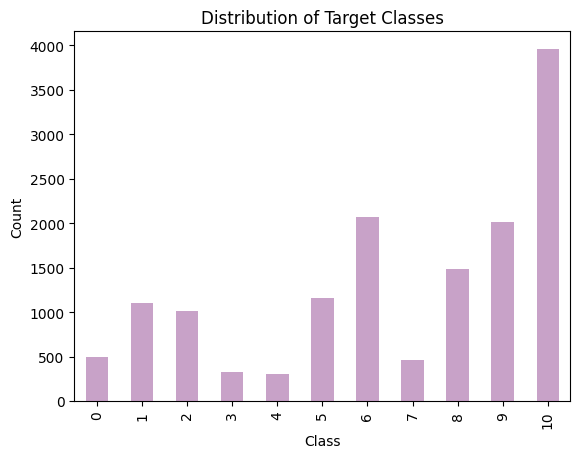

In [12]:
X_train['Class'].value_counts().sort_index().plot(kind='bar', color='#c8a2c8')
plt.title('Distribution of Target Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

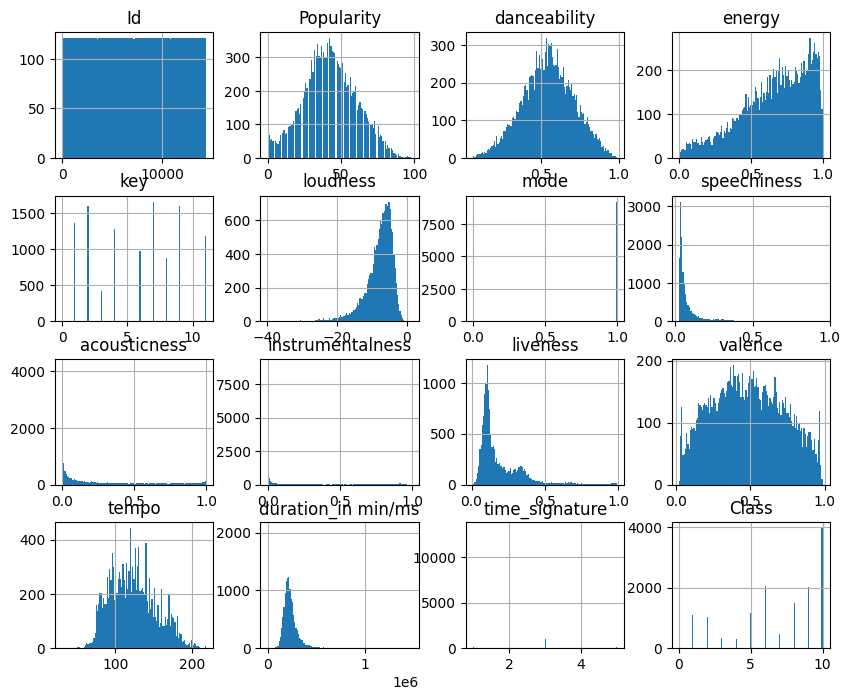

In [10]:
X_train.hist(bins=int(X_train.shape[0] ** 0.5), figsize=(10, 8))
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

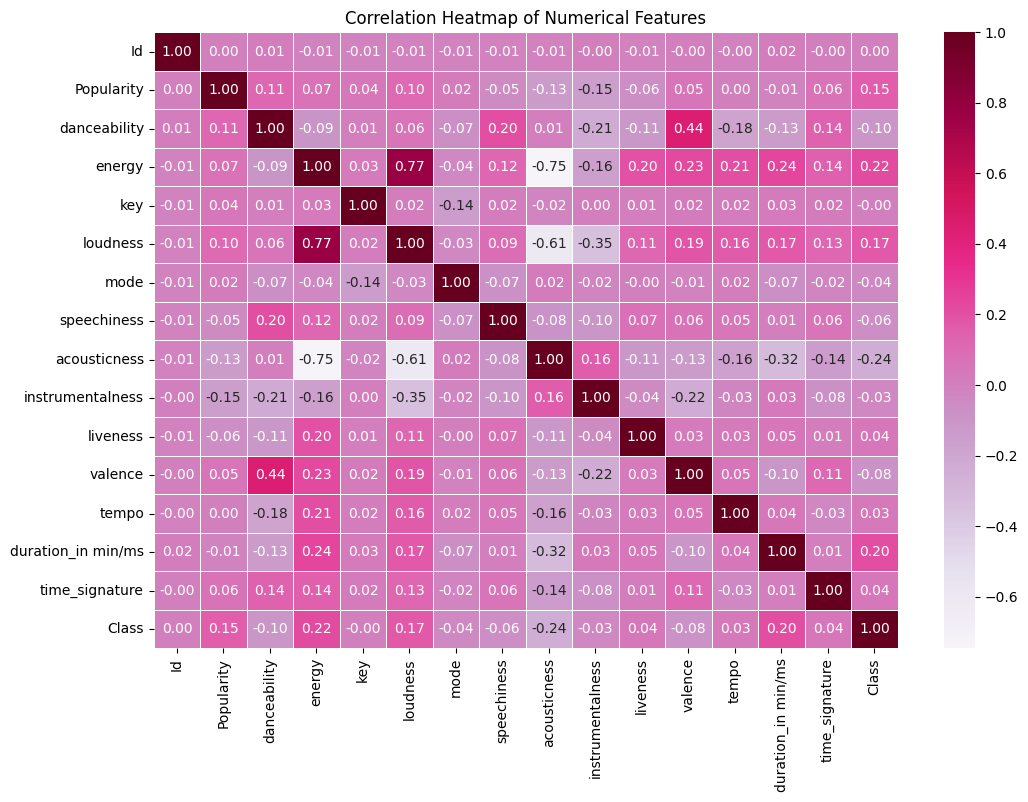

In [14]:
plt.figure(figsize=(12, 8))
sns.heatmap(Numeric_data.corr(), annot=True, cmap='PuRd', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show

<ipython-input-15-46548eb82ad7>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Class', y='Popularity', data=X_train[X_train['Class'].isin(range(1, 11))], palette='PuRd')


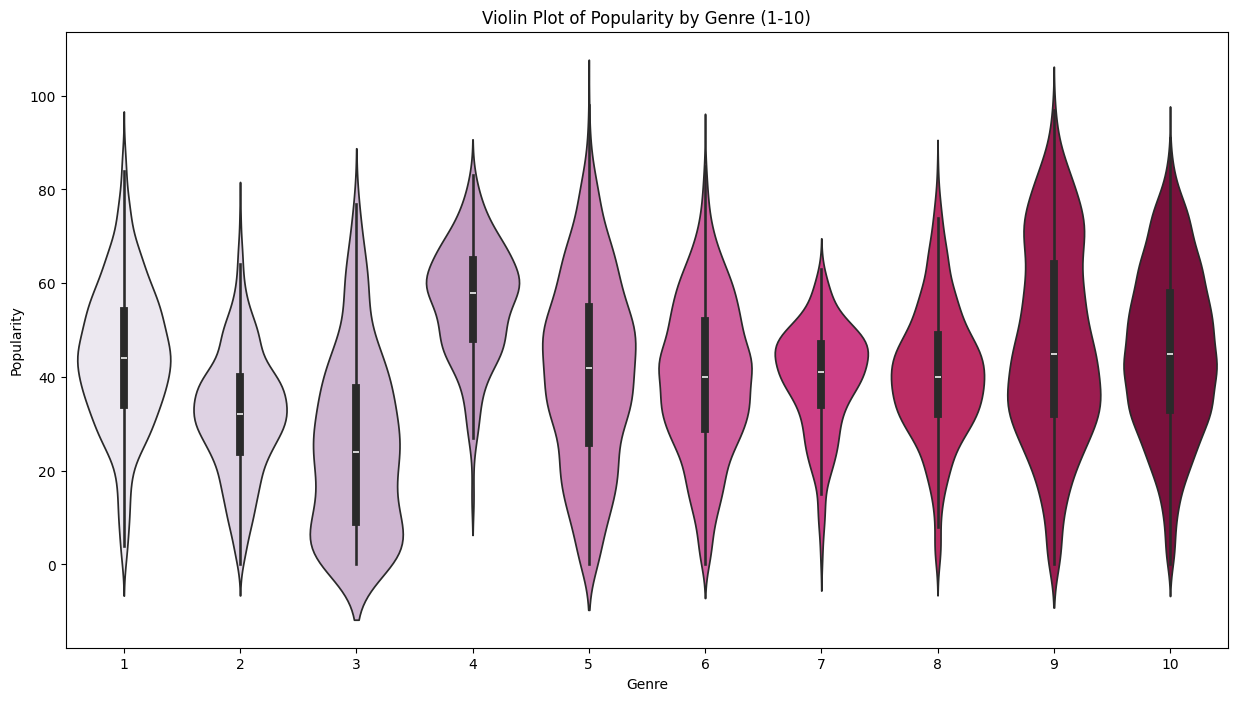

In [15]:
plt.figure(figsize=(15, 8))
sns.violinplot(x='Class', y='Popularity', data=X_train[X_train['Class'].isin(range(1, 11))], palette='PuRd')
plt.title('Violin Plot of Popularity by Genre (1-10)')
plt.xlabel('Genre')
plt.ylabel('Popularity')
plt.show()

<ipython-input-16-74caff3e9475>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Class', y='danceability', data=X_train[X_train['Class'].isin(range(1, 11))], palette='PuRd')


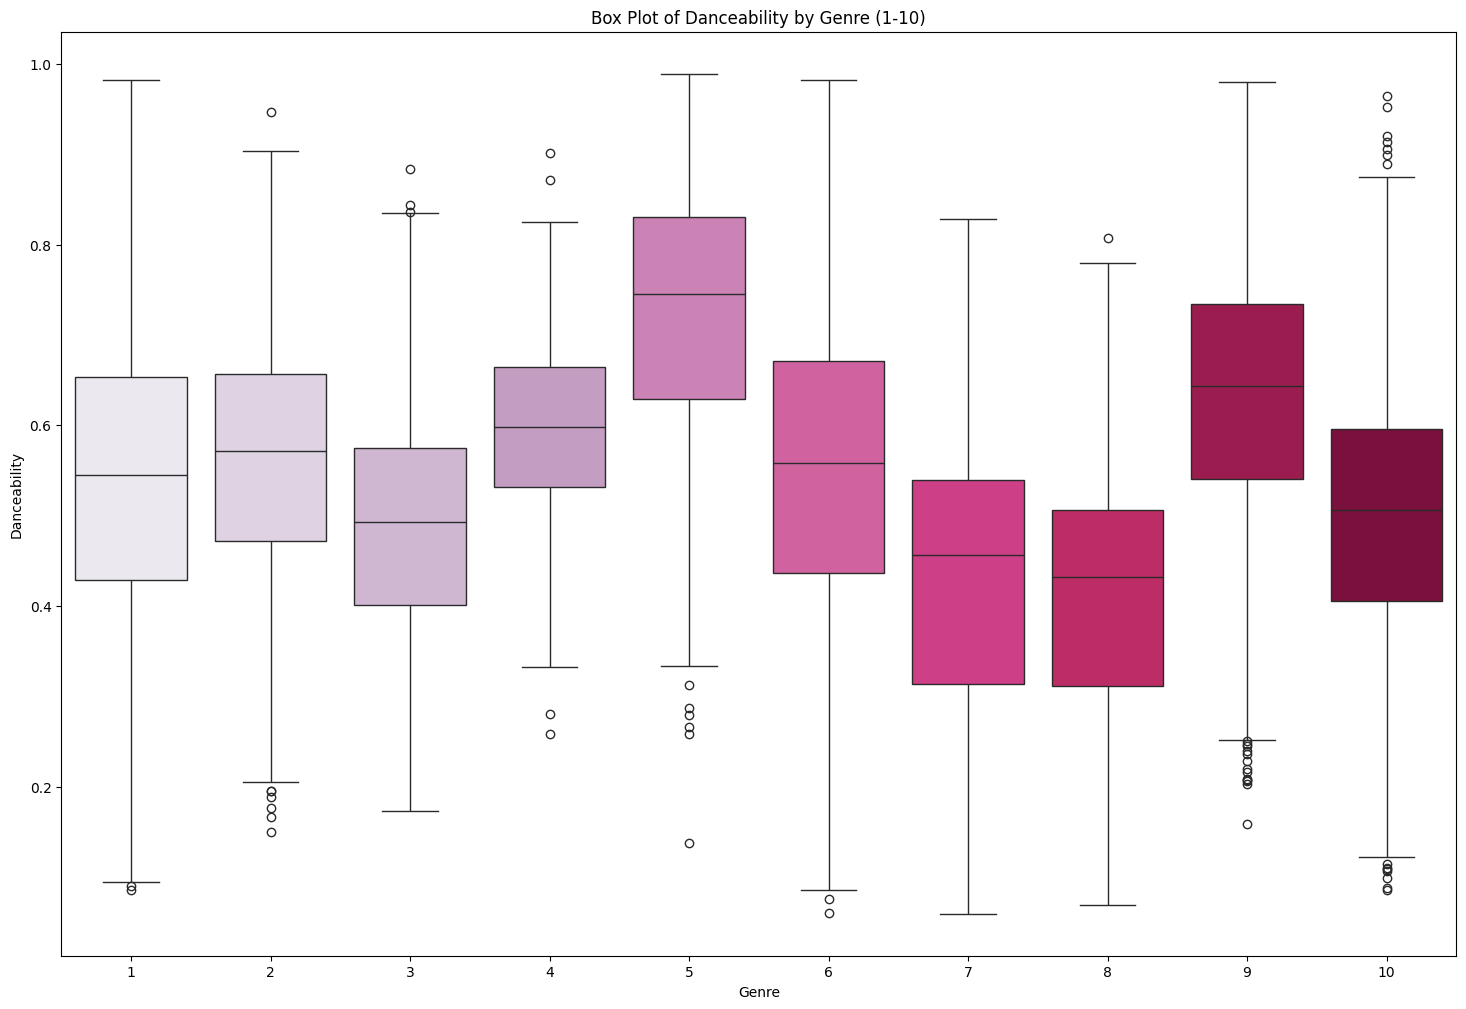

In [16]:
plt.figure(figsize=(18, 12))
sns.boxplot(x='Class', y='danceability', data=X_train[X_train['Class'].isin(range(1, 11))], palette='PuRd')
plt.title('Box Plot of Danceability by Genre (1-10)')
plt.xlabel('Genre')
plt.ylabel('Danceability')
plt.show()

In [17]:
X_train['Popularity'].fillna(X_train['Popularity'].mean(), inplace=True)
X_train['key'].fillna(X_train['key'].mean(), inplace=True)
X_train['instrumentalness'].fillna(X_train['instrumentalness'].mean(), inplace=True)

In [18]:
def filter(x):
  if '◊' in x.lower():
    return True
  else:
    return False

In [19]:
X_train['Symbols']=X_train['Track Name'].apply(filter)

In [20]:
def filter_two(x):
  if '&' in x.lower():
    return True
  else:
    return False

In [21]:
X_train['And']=X_train['Track Name'].apply(filter_two)

In [22]:
X_train

,Id,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class,Symbols,And
0,1,Marina Maximilian,Not Afraid,28.0,0.334,0.536,9.0,-6.649,0,0.0381,0.378000,0.000000,0.1060,0.235,152.429,204947.000000,4,9,False,False
1,2,The Black Keys,Howlin' for You,67.0,0.725,0.747,11.0,-5.545,1,0.0876,0.027200,0.046800,0.1040,0.380,132.921,191956.000000,4,6,False,False
2,3,Royal & the Serpent,phuck u,0.0,0.584,0.804,6.0,-6.094,1,0.0619,0.000968,0.000135,0.2840,0.635,159.953,161037.000000,4,10,False,False
3,4,Detroit Blues Band,Missing You,13.0,0.515,0.308,0.0,-14.711,1,0.0312,0.907000,0.021300,0.3000,0.501,172.472,298093.000000,3,2,False,False
4,5,Coast Contra,My Lady,31.0,0.565,0.777,6.0,-5.096,0,0.2490,0.183000,0.000000,0.2110,0.619,88.311,254145.000000,4,5,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14391,14392,NOISY,I Wish I Was A...,47.0,0.607,0.946,1.0,-2.965,1,0.1500,0.005480,0.000390,0.2780,0.653,120.011,195181.000000,4,10,False,False
14392,14393,BLOODSPOT,Deadline Story (feat. Patrick Boos),27.0,0.435,0.951,8.0,-7.475,1,0.0576,0.000005,0.550000,0.0952,0.203,135.034,282043.000000,4,8,False,False
14393,14394,Cold Years,Too Far Gone,22.0,0.415,0.941,11.0,-4.300,1,0.0524,0.001810,0.000004,0.3370,0.572,167.978,176529.000000,4,10,False,False
14394,14395,The Jaded Hearts Club,Reach Out I'll Be There,37.0,0.493,0.986,1.0,-2.279,1,0.0917,0.000967,0.006620,0.1230,0.567,122.036,186307.000000,4,10,False,False


In [23]:
X_train.groupby('Symbols')['Class'].value_counts()

Symbols  Class
False    10       3695
         6        2023
         9        1596
         8        1483
         1        1098
         5        1025
         2        1018
         0         500
         7         461
         3         322
         4         310
True     9         423
         10        264
         5         132
         6          46
Name: count, dtype: int64

In [24]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
label_encoder = LabelEncoder()
data_encoded = X_train.copy()
data_encoded['Artist Name'] = label_encoder.fit_transform(X_train['Artist Name'].str.lower())
data_encoded['Track Name'] = label_encoder.fit_transform(X_train['Track Name'].str.lower())

In [25]:
encoded_feature_names = list(data_encoded.columns)
encoded_feature_names.remove('Class')

In [26]:
scaler = StandardScaler()
data_encoded[encoded_feature_names] = scaler.fit_transform(data_encoded[encoded_feature_names])

In [27]:
data_encoded[encoded_feature_names]

,Id,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Symbols,And
0,-1.731930,0.164413,0.216192,-0.800351,-1.263390,-0.535777,1.038295,0.308549,-1.334049,-0.494173,0.422160,-0.513814,-0.563774,-1.049740,1.006641,0.043450,0.210416,-0.252838,-0.135088
1,-1.731690,1.191651,-0.497254,1.378335,1.098986,0.358445,1.613849,0.580657,0.749598,0.087129,-0.706136,-0.344666,-0.576333,-0.444231,0.346192,-0.072868,0.210416,-0.252838,-0.135088
2,-1.731449,0.789916,0.366629,-2.364535,0.247081,0.600012,0.174963,0.445342,0.749598,-0.214678,-0.790508,-0.513326,0.553950,0.620630,1.261369,-0.349708,0.210416,-0.252838,-0.135088
3,-1.731209,-0.953117,0.062644,-1.638307,-0.169809,-1.502046,-1.551699,-1.678525,0.749598,-0.575203,2.123611,-0.436830,0.654419,0.061056,1.685203,0.877455,-2.571167,-0.252838,-0.135088
4,-1.730968,-1.110147,0.127683,-0.632760,0.132285,0.485585,0.174963,0.691323,-1.334049,1.982527,-0.205029,-0.513814,0.095557,0.553815,-1.164094,0.483956,0.210416,-0.252838,-0.135088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14391,1.730968,0.434417,-0.413835,0.261060,0.386044,1.201811,-1.263922,1.216560,0.749598,0.819922,-0.775996,-0.512404,0.516274,0.695797,-0.090880,-0.043992,0.210416,-0.252838,-0.135088
14392,1.731209,-1.330862,-1.077230,-0.856214,-0.653160,1.223001,0.750518,0.104962,0.749598,-0.265175,-0.793604,1.474034,-0.631591,-1.183370,0.417728,0.733748,0.210416,-0.252838,-0.135088
14393,1.731449,-1.101423,1.172260,-1.135533,-0.773998,1.180620,1.613849,0.887517,0.749598,-0.326241,-0.787800,-0.513801,0.886755,0.357547,1.533057,-0.210997,0.210416,-0.252838,-0.135088
14394,1.731690,1.264059,0.465884,-0.297577,-0.302731,1.371331,-1.263922,1.385641,0.749598,0.135277,-0.790511,-0.489887,-0.457025,0.336667,-0.022323,-0.123447,0.210416,-0.252838,-0.135088


In [28]:
data_encoded.head()

,Id,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class,Symbols,And
0,-1.731930,0.164413,0.216192,-0.800351,-1.263390,-0.535777,1.038295,0.308549,-1.334049,-0.494173,0.422160,-0.513814,-0.563774,-1.049740,1.006641,0.043450,0.210416,9,-0.252838,-0.135088
1,-1.731690,1.191651,-0.497254,1.378335,1.098986,0.358445,1.613849,0.580657,0.749598,0.087129,-0.706136,-0.344666,-0.576333,-0.444231,0.346192,-0.072868,0.210416,6,-0.252838,-0.135088
2,-1.731449,0.789916,0.366629,-2.364535,0.247081,0.600012,0.174963,0.445342,0.749598,-0.214678,-0.790508,-0.513326,0.553950,0.620630,1.261369,-0.349708,0.210416,10,-0.252838,-0.135088
3,-1.731209,-0.953117,0.062644,-1.638307,-0.169809,-1.502046,-1.551699,-1.678525,0.749598,-0.575203,2.123611,-0.436830,0.654419,0.061056,1.685203,0.877455,-2.571167,2,-0.252838,-0.135088
4,-1.730968,-1.110147,0.127683,-0.632760,0.132285,0.485585,0.174963,0.691323,-1.334049,1.982527,-0.205029,-0.513814,0.095557,0.553815,-1.164094,0.483956,0.210416,5,-0.252838,-0.135088


In [30]:
data_encoded= data_encoded.drop(['Id'], axis =1)

In [29]:
X = data_encoded.drop(columns=['Class'])
y = data_encoded['Class']

In [30]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)

In [31]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

In [32]:
classifiers = {
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
}

In [ ]:
accuracy_dict = {}
f1_scores = {}


Training and evaluating Gradient Boosting...
Accuracy (Gradient Boosting): 0.5624
Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.75      0.70       131
           1       0.17      0.02      0.04       255
           2       0.61      0.46      0.52       286
           3       0.83      0.72      0.77        90
           4       0.64      0.64      0.64        85
           5       0.72      0.70      0.71       292
           6       0.45      0.38      0.41       509
           7       0.92      0.94      0.93       109
           8       0.63      0.59      0.61       359
           9       0.56      0.59      0.58       502
          10       0.49      0.68      0.57       981

    accuracy                           0.56      3599
   macro avg       0.61      0.59      0.59      3599
weighted avg       0.54      0.56      0.54      3599



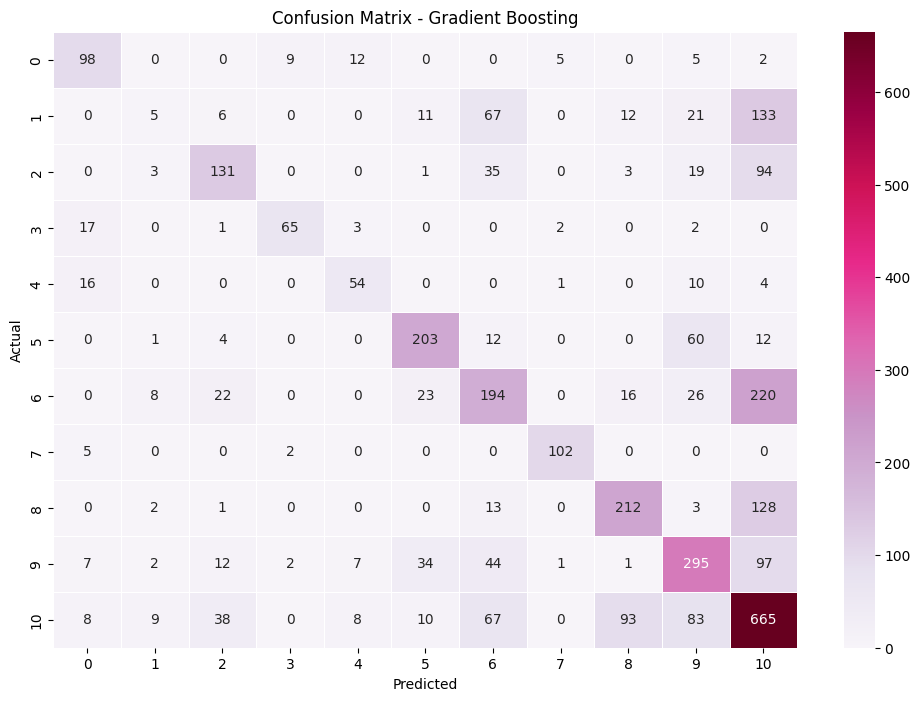


Training and evaluating Random Forest...
Accuracy (Random Forest): 0.5301
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.81      0.73       131
           1       0.07      0.04      0.05       255
           2       0.63      0.38      0.47       286
           3       0.86      0.73      0.79        90
           4       0.68      0.68      0.68        85
           5       0.70      0.72      0.71       292
           6       0.39      0.33      0.36       509
           7       0.94      0.94      0.94       109
           8       0.63      0.52      0.57       359
           9       0.54      0.52      0.53       502
          10       0.47      0.64      0.54       981

    accuracy                           0.53      3599
   macro avg       0.60      0.57      0.58      3599
weighted avg       0.52      0.53      0.52      3599



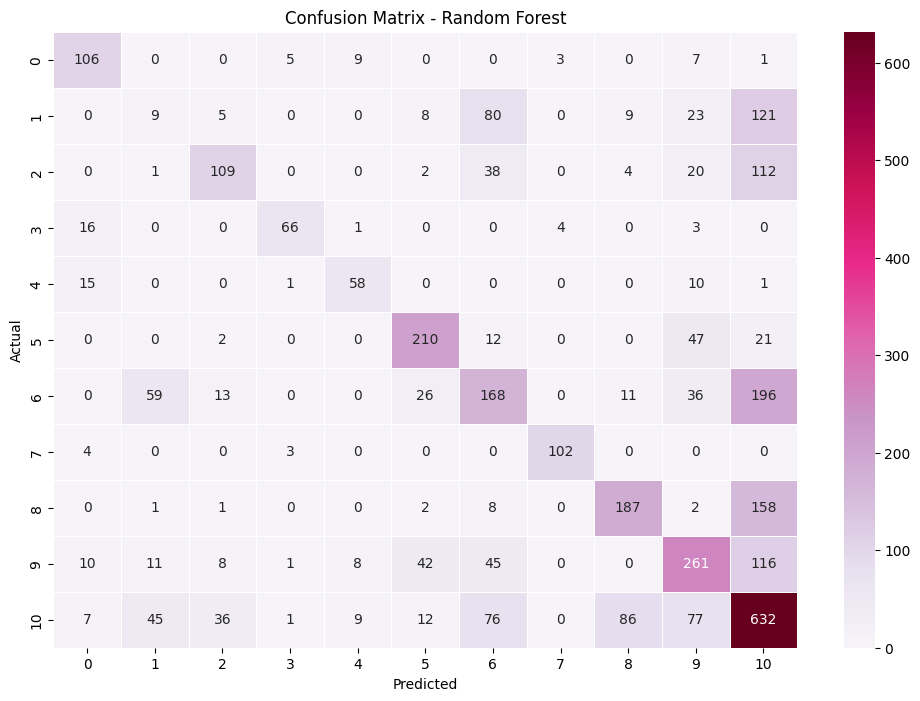

In [ ]:
for clf_name, clf in classifiers.items():
    print(f"\nTraining and evaluating {clf_name}...")

    clf.fit(Xtrain, ytrain)
    y_pred = clf.predict(Xtest)

    accuracy = accuracy_score(ytest, y_pred)
    accuracy_dict[clf_name] = accuracy
    class_report = classification_report(ytest, y_pred)

    print(f"Accuracy ({clf_name}): {accuracy:.4f}")
    print("Classification Report:")
    print(class_report)
    cm = confusion_matrix(ytest, y_pred)
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d',linewidths=0.5, cmap='PuRd', )
    plt.title(f"Confusion Matrix - {clf_name}"),
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


Training and evaluating Gradient Boosting...
Accuracy (Gradient Boosting): 0.5599
Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.76      0.69       131
           1       0.17      0.02      0.04       255
           2       0.60      0.44      0.51       286
           3       0.83      0.70      0.76        90
           4       0.64      0.64      0.64        85
           5       0.71      0.69      0.70       292
           6       0.45      0.39      0.41       509
           7       0.93      0.94      0.93       109
           8       0.63      0.60      0.61       359
           9       0.57      0.58      0.57       502
          10       0.49      0.67      0.57       981

    accuracy                           0.56      3599
   macro avg       0.60      0.58      0.58      3599
weighted avg       0.54      0.56      0.54      3599



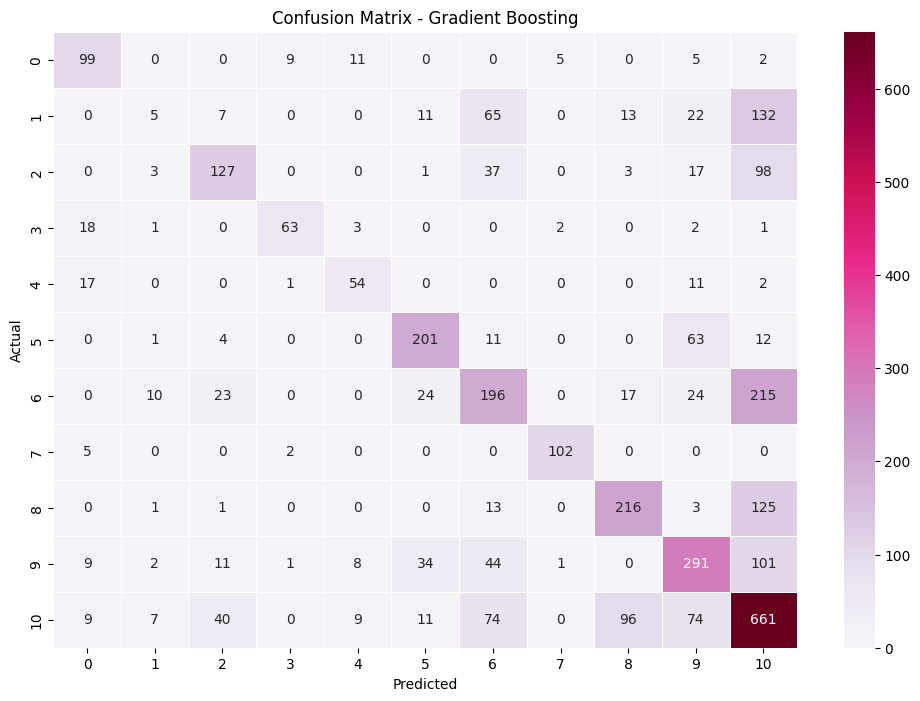


Training and evaluating Random Forest...
Accuracy (Random Forest): 0.5315
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.79      0.73       131
           1       0.07      0.04      0.05       255
           2       0.60      0.40      0.48       286
           3       0.85      0.76      0.80        90
           4       0.69      0.69      0.69        85
           5       0.71      0.74      0.73       292
           6       0.37      0.31      0.34       509
           7       0.94      0.95      0.95       109
           8       0.61      0.51      0.56       359
           9       0.56      0.53      0.55       502
          10       0.47      0.64      0.54       981

    accuracy                           0.53      3599
   macro avg       0.60      0.58      0.58      3599
weighted avg       0.52      0.53      0.52      3599



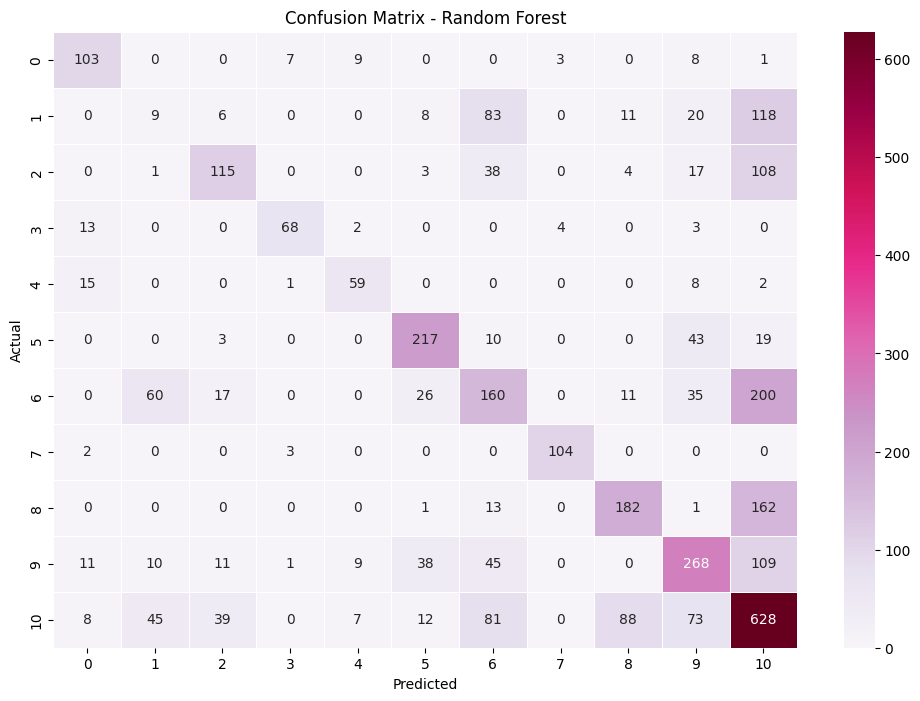


Best Model: Gradient Boosting
Accuracy of Best Model: 0.5599
F1 Score of Best Model: 0.5842


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming classifiers is a dictionary of classifier name and classifier object pairs
accuracy_dict = {}
f1_scores = {}

# Train and evaluate each classifier
for clf_name, clf in classifiers.items():
    print(f"\nTraining and evaluating {clf_name}...")

    # Fit the model
    clf.fit(Xtrain, ytrain)
    # Predict on test set
    y_pred = clf.predict(Xtest)

    # Calculate accuracy
    accuracy = accuracy_score(ytest, y_pred)
    accuracy_dict[clf_name] = accuracy

    # Calculate F1 score
    f1 = f1_score(ytest, y_pred, average='macro')  # 'macro' for multiclass
    f1_scores[clf_name] = f1

    # Display results
    print(f"Accuracy ({clf_name}): {accuracy:.4f}")
    print("Classification Report:")
    print(classification_report(ytest, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(ytest, y_pred)
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.heatmap(cm, annot=True, fmt='d', linewidths=0.5, cmap='PuRd')
    plt.title(f"Confusion Matrix - {clf_name}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Ensure there's no conflict with the 'max' function
best_model = max(accuracy_dict, key=accuracy_dict.get)

# Display the best model and its F1 score
print(f"\nBest Model: {best_model}")
print(f"Accuracy of Best Model: {accuracy_dict[best_model]:.4f}")
print(f"F1 Score of Best Model: {f1_scores[best_model]:.4f}")

In [33]:
# Define base models
base_models = [
    ('lr', LogisticRegression(max_iter=1000)),  # Logistic Regression
    ('rf', RandomForestClassifier(n_estimators=100)),  # Random Forest
    ('svc', SVC(probability=True))  # Support Vector Classifier
]


In [34]:
stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression()  # You can use any model as a final estimator
)

In [35]:
stacking_clf.fit(Xtrain, ytrain)

StackingClassifier(estimators=[('lr', LogisticRegression(max_iter=1000)),
                               ('rf', RandomForestClassifier()),
                               ('svc', SVC(probability=True))],
                   final_estimator=LogisticRegression())

In [36]:
y_pred = stacking_clf.predict(Xtest)

In [37]:
print(classification_report(ytest, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.78      0.73       131
           1       0.44      0.11      0.18       255
           2       0.59      0.38      0.46       286
           3       0.87      0.76      0.81        90
           4       0.67      0.61      0.64        85
           5       0.74      0.69      0.71       292
           6       0.47      0.40      0.43       509
           7       0.94      0.94      0.94       109
           8       0.61      0.52      0.56       359
           9       0.54      0.57      0.55       502
          10       0.47      0.67      0.55       981

    accuracy                           0.55      3599
   macro avg       0.64      0.58      0.60      3599
weighted avg       0.56      0.55      0.54      3599

